**1: Group all the import statement together for flexibility.**

In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans

import pandas as pd
from pandas import json_normalize
import numpy as np

%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns; sns.set()

import timeit as timer
from time import time
from datetime import datetime

from IPython.display import display, HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Run the following command for mouting the drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**2: Using firebase_admin module to connect to firebase realtime database.**

In [3]:
def connect_to_firebase_db():
  if(not len(firebase_admin._apps)):
    cred = credentials.Certificate('/content/drive/My Drive/Colab Notebooks/project/accident-repo-firebase-adminsdk-py9r9-57a568934d.json') ## The path to the service json key needs to be changed here!!! Currently mapped to my local path
    app = firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://accident-repo.firebaseio.com/'
    })
    print('initialized')
  else:
    firebase_admin.delete_app(firebase_admin.get_app())
    print('deleted')

# Calling the function
connect_to_firebase_db()


initialized


3: **Getting data from the firestore database.**

In [0]:
def get_data():
  accidentReport_ref = db.reference()

  # Starting timer to track how long it takes to load the data from the database
  startTime = timer.default_timer()

  results = accidentReport_ref.order_by_key().limit_to_first(100000).get() #change the limit_to_first function later, Right now get the first 100000 data!!!

  stopTime = timer.default_timer()
  print('{} data retrieved in: {} seconds!!'.format(len(results), stopTime - startTime))

  return results

**4: Storing the documents from firebase db into pandas dataframe**.

In [0]:
def import_and_store_data():
  
  # calling get_data()
  result = get_data()
  data = result.values() # We separate the auto generated keys by firebase 

  #Since we have nested document semi structured database, we need to normalize our database to flatten it!
  data = json_normalize(data, max_level=1)
  print(data)

  df = pd.DataFrame(data)
  
  print("Dimesion of the data: ", df.shape)
  num_of_rows = df.shape[0]
  num_of_columns = df.shape[1]
  print('Number of Rows: {}'.format(num_of_rows))
  print('Number of Columns: {}'.format(num_of_columns))

  print('Data retrieved!!!')

  return df

**Note:** List of column in the database


```
  accident_severity
  date
  location.latitude
  location.location_easting_OSGR
  location.location_northing_OSGR
  location.longitude
  location.urban_or_rural
  number_of_casualties
  number_of_vehicles
  road.carriageway_hazard
  road.first_road_class
  road.first_road_number
  road.junction_control
  road.light_condition
  road.pedestrian_crossing_human_control
  road.pedestrian_crossing_physical_facilities
  road.road_surface_condition
  road.road_type
  road.second_road_class
  road.second_road_number
  road.special_condition_at_site
  road.speed_limit
  weather.condition
  time

```


  

**Note:**  **!! Business Requirements !!**
 

```
1.   Find any relation between accident_severity, and road.speed_limit.
2.   Find any relation between accident_severity, and road.road_surface_condition.
3.   Find any relation between accident_severity and weather condition.
4.   Find any relation between accident_severity and light condition.
5.   Find any relation between accident_severity, and number_of_vehicles.
6.   Find any relation between accident_severity, and time of day.

```


**5: Defining all the features used for Data Modeling. Creating data matrices from the DataFrame object.**

In [0]:
def create_matrices(dataFrame):

  features_set1 = ['accident_severity', 'road.speed_limit']
  features_set2 = ['accident_severity', 'time']
  features_set3 = ['accident_severity', 'number_of_vehicles']
  features_set4 = ['accident_severity', 'road.road_surface_condition']
  features_set5 = ['accident_severity', 'road.light_condition']
  features_set6 = ['accident_severity', 'weather.condition']

  matrices = []
  matrices.append(dataFrame[features_set1])
  matrices.append(dataFrame[features_set2])
  matrices.append(dataFrame[features_set3])
  matrices.append(dataFrame[features_set4])
  matrices.append(dataFrame[features_set5])
  matrices.append(dataFrame[features_set6])

  return matrices


**6: Handling the non numerical data inside the given Dataframe.**

**Important Note->** When Calling this function always pass the copy of the original dataframe in order to not change the originial dataframe in the process. Eg: ***numerical_df = handle_non_numerical_date(df.copy())***

**Note->** This is very important inorder to model our dataset. Because our dataset consist of textual data so we have to convert them to numerical data using simple feature extraction technique.!!!!!!!!!!

In [0]:
def handle_non_numerical_data(df_temp):
  
  # Print the first 20 data entries from non-numerical dataframe
  print('\n\n Actual dataframe \n\n')
  display(df_temp.head(20))

  columns = df_temp.columns.values
  for column in columns:
    text_digit_vals = {}
    def convert_to_int(val):
      return text_digit_vals[val]

    if column == 'accident_severity' or column == 'number_of_vehicles' or column == 'number_of_casualties' or column == 'location.location_easting_OSGR' or column == 'location.location_northing_OSGR' or column == 'road.speed_limit' or column == 'road.first_road_class' or column == 'road.second_road_class' or column == 'road.first_road_number' or column == 'road.second_road_number' or column == 'location.urban_or_rural_area':
      df_temp[column] = df_temp[column].astype(int)
    elif column == 'location.latitude' or column == 'location.longitude':
      df_temp[column] = df_temp[column].astype(float)
    elif column == 'date':
      df_temp[column] = pd.to_datetime(df_temp[column]).view(int)/10000000000
    elif column == 'time':
      df_temp[column] = pd.to_datetime(df_temp[column]).dt.hour
    elif column == 'weather.condition' or column == 'road.junction_control' or column == 'road.light_condition' or column == 'road.pedestrian_crossing_human_control' or column == 'road.pedestrian_crossing_physical_facilities' or column == 'road.road_surface_condition' or column == 'road.road_type' or column == 'road.special_condition_at_site' or column == 'road.carriageway_hazard':
      column_values = df_temp[column].values.tolist()
      unique_values = set(column_values)
      x = 0
      for unique_val in unique_values:
        if unique_val not in text_digit_vals:
          text_digit_vals[unique_val] = x
          x += 1

      df_temp[column] = list(map(convert_to_int, df_temp[column]))

  # Print the first 20 data entries from numerical dataframe
  print('\n\n Numerical Dataframe \n\n')
  display(df_temp.head(20))

  return df_temp


**7-a: Function that uses Isolation Forest to find the anamolies in the given dataset**

In [0]:
def isolate_anamolies(X):
  iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")
  
  # Get Start time
  t0 = time()
  iso_forest.fit(X)
  # Get End time
  time_taken_iso_forest = time() - t0
  print('\n Isolation Forest: Running Time = %0.3fs' % time_taken_iso_forest)

  #  Predict the outlier: 1 for an inlier and -1 for an outlier
  X_prediction = iso_forest.predict(X)

  #  Getting the anamoly score for the outliers in X
  X_anamoly_score = iso_forest.decision_function(X)

  # Create a dictionary of the anamoly score values
  X_anamoly_score_dict = {}

  # For each anamoly score value, add an index starting from 0 to correspond to the actual data indices
  for i in range(len(X_anamoly_score)):
    X_anamoly_score_dict[i] = X_anamoly_score[i]

  # Sort the anamoly score values in their increasing order
  sorted_X_anamoly_score_dict = {k: v for k, v in sorted(X_anamoly_score_dict.items(), key=lambda item: item[1])}

  # Get the indices of the data points for the sorted anamoly score values 
  sorted_X_anamoly_score_dict_keys =  sorted_X_anamoly_score_dict.keys()

  #returns the keys or index of sorted data a/c to anamoly score from the dataframe
  return sorted_X_anamoly_score_dict_keys
  

**7-b: Using isolate_anamolies(matrix) function to detect and Drop Top 1000 outliers / anamolies for given feature set**

In [0]:
def remove_top_20000_outliers(matrix):

  anamolies = isolate_anamolies(matrix)
  for i in range(20000):
    key = list(anamolies)[i]
    if i in range(10):
      print('\n Outlier Rank: {} \n accident: {}'.format(i+1, matrix.iloc[key]))

    matrix.drop([key])

  print('\n Top 20000 outliers were dropped from the matrix dataframe for the given feature set');

  return matrix

**8-a: Finding the optimal number of components using Bayesian information criterion (BIC) and Akaike information criterion (AIC).**

In [0]:
def optimal_k_GMM(X):
  gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in range(1, 10)]

  bics = [model.bic(X) for model in gms_per_k]
  aics = [model.aic(X) for model in gms_per_k]

  plt.figure(figsize=(12, 6))
  plt.plot(range(1, 10), bics, "bo-", label="BIC")
  plt.plot(range(1, 10), aics, "go--", label="AIC")

  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Information Criterion", fontsize=14)
  plt.legend()
  plt.show()

  optimal_k = MinBIC(bics)
  print("\n Optimal number of components for the given Feature Set is: {}".format(optimal_k))

  return optimal_k

# Finds the value of "k" that gives minimum BIC
def MinBIC(bics): 
    neighbors = np.arange(1,10)
    j = 0
    min_bic = bics[j]
    max_k = 1
    for i in neighbors:
        if(bics[j] < min_bic):
            min_bic = bics[j]
            max_k = i
        j +=1
    return max_k


**8-b: Finding the optimal number of components using K_Means Silhouette score.**

In [0]:
def optimal_k_Silhouette_Score(X):
  kmeans_per_k = [KMeans(n_clusters=k, init="k-means++").fit(X)
                 for k in range(1, 15)]

  inertias = [model.inertia_ for model in kmeans_per_k] 

  #plot inertia vs k
  plt.figure(figsize=(12, 5.5))
  plt.plot(range(1, 15), inertias, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Inertia", fontsize=14)
  plt.show()

  #plot silhouette score vs k
  silhouette_scores = [silhouette_score(X, model.labels_)
                      for model in kmeans_per_k[1:]]

  silhouette_score_per_cluster = {}
  for cluster in range(len(silhouette_scores)):
    silhouette_score_per_cluster.update({(cluster + 2): silhouette_scores[cluster]})

  print('\n Silhouette Scores: {}'.format(silhouette_score_per_cluster))                 

  plt.figure(figsize=(10, 4))
  plt.plot(range(2, 15), silhouette_scores, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)
  plt.show()

  optimal_K = max_silhouette_score(silhouette_scores)
  print("\n Optimal number of components for the given Feature Set is: {}".format(optimal_K))

  return optimal_K   


#Get the index(cluster) with max Silhouette score
def max_silhouette_score(silhouette_scores):
  clusters = np.arange(2,len(silhouette_scores)-1)
  j = 1 # To make sure we don't end up with optimal k = 0
  max_sil_score = silhouette_scores[j]
  optimal_k = 0
  for i in clusters:
    if(max_sil_score < silhouette_scores[j]):
      max_sil_score = silhouette_scores[j]
      optimal_k = i
    j += 1
  return optimal_k     

**9-a: Train a GMM model using optimal k!**

In [0]:
def model_data(matrix):

  #Find optimal k for entire feature set
  startTime1 = timer.default_timer()

  #Get optimal k

  optimal_K_GMM = optimal_k_GMM(matrix)
  optimal_K_Sil_Score = optimal_k_Silhouette_Score(matrix);

  #Get the lowest optimal_K out of 2
  optimal_K = np.minimum(optimal_K_GMM, optimal_K_Sil_Score)

  stopTime1 = timer.default_timer()
  print('\n Optimal k retrieved in: {} seconds!! \n'.format(stopTime1 - startTime1))

  #Train a model using optimal k
  startTime2 = timer.default_timer()

  gmm = GaussianMixture(n_components=optimal_K, n_init=10, random_state=42)
  gmm.fit(matrix)

  stopTime2 = timer.default_timer()
  print('\n Gaussian preformed in: {} seconds!! \n'.format(stopTime2 - startTime2))

  #Predict the labels for the data samples in data using trained model.
  predictedLabels = gmm.predict(matrix)
  different_labels = np.unique(predictedLabels)


  #Get size of each cluster
  size_of_clusters = {}
  for cluster in different_labels:
      cluster_size = 0
      for i in predictedLabels:
          if i == cluster:
              cluster_size +=1
      size_of_clusters.update({cluster: cluster_size})
      
  print('\n Cluster Sizes:  {}'.format(size_of_clusters)) 

  # Getting average for each cluster
  return getGMMaverages(matrix, predictedLabels, matrix.columns, optimal_K)

**9-b: Print the averages of each cluster**

In [0]:
def getGMMaverages(data, labels, features, cluster_size):  # Getting average for each Feature inside every cluster
  indices_in_cluster = [[] for i in range(cluster_size)]
  cluster_means = [[] for i in range(cluster_size)]
  mean_df = pd.DataFrame(columns = features)
  

  for cluster_number in range(cluster_size):
    indices_in_cluster[cluster_number] = np.where(labels == cluster_number)
    
  for cluster_number in range(cluster_size):
    cluster = data.iloc[indices_in_cluster[cluster_number][0]]
    cluster_means[cluster_number] = np.round(cluster.mean(axis=0))

  for cluster_number in range(cluster_size):
    mean_df = mean_df.append(cluster_means[cluster_number], ignore_index = True)

  return mean_df

**9-c: Calling model_data function to train GMM with our data**

In [14]:
# #!!!!!!!!!!!!!! GETTING DATA FROM CSV to save READ and WRITES !!!!!!!!!!!!!!!!
# numerical_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project/our_data.csv')

##    Getting data from the firebase realtime database  ####
data = import_and_store_data()
numerical_data = handle_non_numerical_data(data.copy())

# numerical_data.to_csv('our_data.csv')

# Calling the function to create data matrices for the user defined feature sets
matrices = create_matrices(numerical_data)


100000 data retrieved in: 148.6370321850004 seconds!!
       accident_severity  ...           weather.condition
0                      3  ...     Fine without high winds
1                      3  ...     Fine without high winds
2                      3  ...     Fine without high winds
3                      3  ...     Fine without high winds
4                      3  ...     Fine without high winds
...                  ...  ...                         ...
99995                  3  ...     Fine without high winds
99996                  3  ...     Fine without high winds
99997                  3  ...  Raining without high winds
99998                  3  ...     Fine without high winds
99999                  3  ...     Fine without high winds

[100000 rows x 24 columns]
Dimesion of the data:  (100000, 24)
Number of Rows: 100000
Number of Columns: 24
Data retrieved!!!


 Actual dataframe 




,accident_severity,date,number_of_casualties,number_of_vehicles,time,location.latitude,location.location_easting_OSGR,location.location_northing_OSGR,location.longitude,location.urban_or_rural,road.carriageway_hazard,road.first_road_class,road.first_road_number,road.junction_control,road.light_condition,road.pedestrian_crossing_human_control,road.pedestrian_crossing_physical_facilities,road.road_surface_condition,road.road_type,road.second_road_class,road.second_road_number,road.special_condition_at_site,road.speed_limit,weather.condition
0,3,19/01/2012,1,2,20:35,51.493429,527200,178760,-0.169101,1,None,3,308,Automatic traffic signal,Darkness: Street lights present and lit,None within 50 metres,Pedestrian phase at traffic signal junction,Dry,Single carriageway,5,0,None,30,Fine without high winds
1,3,4/1/12,1,2,17:00,51.517931,524930,181430,-0.200838,1,None,4,412,Giveway or uncontrolled,Darkness: Street lights present and lit,None within 50 metres,No physical crossing within 50 meters,Dry,Single carriageway,6,0,None,30,Fine without high winds
2,3,10/1/12,1,2,10:07,51.487618,525860,178080,-0.188636,1,None,3,3220,Giveway or uncontrolled,Daylight: Street light present,None within 50 metres,non-junction pedestrian crossing,Dry,One way street,6,0,None,30,Fine without high winds
3,3,18/01/2012,1,1,12:20,51.514325,524980,181030,-0.200259,1,None,5,0,Giveway or uncontrolled,Daylight: Street light present,None within 50 metres,No physical crossing within 50 meters,Dry,Single carriageway,6,0,None,30,Fine without high winds
4,3,17/01/2012,1,1,20:24,51.497614,526170,179200,-0.183773,1,None,4,325,Giveway or uncontrolled,Darkness: Street lights present and lit,None within 50 metres,No physical crossing within 50 meters,Dry,Single carriageway,6,0,None,30,Fine without high winds
5,3,19/01/2012,1,2,7:30,51.483253,526090,177600,-0.185496,1,None,3,308,Automatic traffic signal,Darkness: Street lights present and lit,None within 50 metres,Pedestrian phase at traffic signal junction,Wet/Damp,Single carriageway,3,3220,None,30,Raining without high winds
6,3,12/1/12,1,1,14:00,51.501567,527780,179680,-0.160418,1,None,3,3216,Automatic traffic signal,Daylight: Street light present,None within 50 metres,Pedestrian phase at traffic signal junction,Dry,Single carriageway,3,4,None,30,Fine without high winds
7,3,7/1/12,1,2,11:29,51.523975,524010,182080,-0.213862,1,None,4,450,Giveway or uncontrolled,Daylight: Street light present,None within 50 metres,Zebra crossing,Dry,Roundabout,5,0,None,30,Fine without high winds
8,3,7/1/12,1,2,13:55,51.498077,527710,179290,-0.161567,1,None,6,0,Giveway or uncontrolled,Daylight: Street light present,None within 50 metres,No physical crossing within 50 meters,Dry,One way street,6,0,None,30,Fine without high winds
9,3,4/1/12,1,2,19:40,51.505576,525120,180060,-0.198587,1,None,5,0,Giveway or uncontrolled,Darkness: Street lights present and lit,None within 50 metres,No physical crossing within 50 meters,Wet/Damp,Single carriageway,6,0,None,30,Raining without high winds




 Numerical Dataframe 




,accident_severity,date,number_of_casualties,number_of_vehicles,time,location.latitude,location.location_easting_OSGR,location.location_northing_OSGR,location.longitude,location.urban_or_rural,road.carriageway_hazard,road.first_road_class,road.first_road_number,road.junction_control,road.light_condition,road.pedestrian_crossing_human_control,road.pedestrian_crossing_physical_facilities,road.road_surface_condition,road.road_type,road.second_road_class,road.second_road_number,road.special_condition_at_site,road.speed_limit,weather.condition
0,3,132693120.0,1,2,20,51.493429,527200,178760,-0.169101,1,0,3,308,0,3,0,2,3,4,5,0,0,30,6
1,3,133323840.0,1,2,17,51.517931,524930,181430,-0.200838,1,0,4,412,2,3,0,1,3,4,6,0,0,30,6
2,3,134904960.0,1,2,10,51.487618,525860,178080,-0.188636,1,0,3,3220,2,4,0,5,3,1,6,0,0,30,6
3,3,132684480.0,1,1,12,51.514325,524980,181030,-0.200259,1,0,5,0,2,4,0,1,3,4,6,0,0,30,6
4,3,132675840.0,1,1,20,51.497614,526170,179200,-0.183773,1,0,4,325,2,3,0,1,3,4,6,0,0,30,6
5,3,132693120.0,1,2,7,51.483253,526090,177600,-0.185496,1,0,3,308,0,3,0,2,4,4,3,3220,0,30,0
6,3,135432000.0,1,1,14,51.501567,527780,179680,-0.160418,1,0,3,3216,0,4,0,2,3,4,3,4,0,30,6
7,3,134110080.0,1,2,11,51.523975,524010,182080,-0.213862,1,0,4,450,2,4,0,3,3,0,5,0,0,30,6
8,3,134110080.0,1,2,13,51.498077,527710,179290,-0.161567,1,0,6,0,2,4,0,1,3,1,6,0,0,30,6
9,3,133323840.0,1,2,19,51.505576,525120,180060,-0.198587,1,0,5,0,2,3,0,1,4,4,6,0,0,30,0


**9-d: GMM on Feature Set 1 (Accident_severity, speed_limit)**



 Result of GMM Modeling for feature Set 1 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    5.4s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 2.291s

 Outlier Rank: 1 
 accident: accident_severity     1
road.speed_limit     70
Name: 21203, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity     1
road.speed_limit     70
Name: 22271, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity     1
road.speed_limit     70
Name: 22532, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity     1
road.speed_limit     70
Name: 28304, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity     1
road.speed_limit     70
Name: 29777, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity     1
road.speed_limit     70
Name: 30752, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity     1
road.speed_limit     70
Name: 32017, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity     1
road.speed_limit     70
Name: 44336, dtype: int64

 Outlier Rank: 9 
 accident: accident_severity     1
road.speed_limit     70
Name: 45404, dtype: int64

 Outlier Rank: 10 
 a

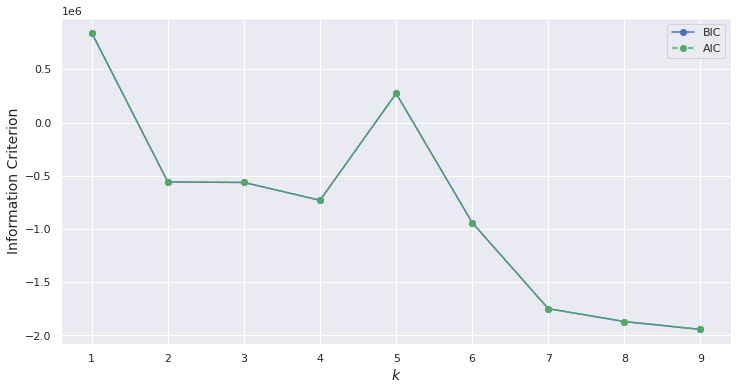


 Optimal number of components for the given Feature Set is: 9


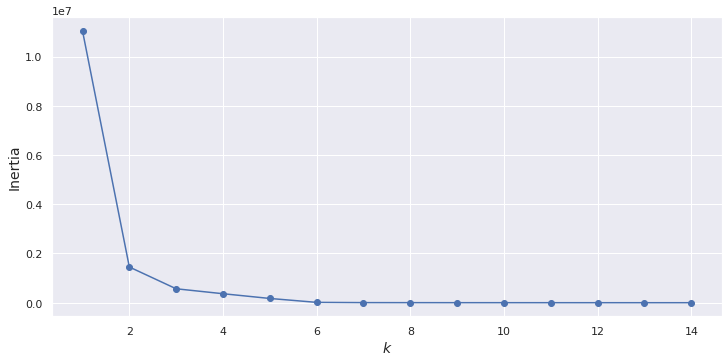


 Silhouette Scores: {2: 0.8933522239552208, 3: 0.909040187585049, 4: 0.9140758956742945, 5: 0.9512695629463538, 6: 0.9743186712104074, 7: 0.9874752847848223, 8: 0.9881787217758102, 9: 0.9891196347474278, 10: 0.9953687101964523, 11: 0.9954572523877511, 12: 0.9957738051930589, 13: 0.996082714391585, 14: 0.9979147200814854}


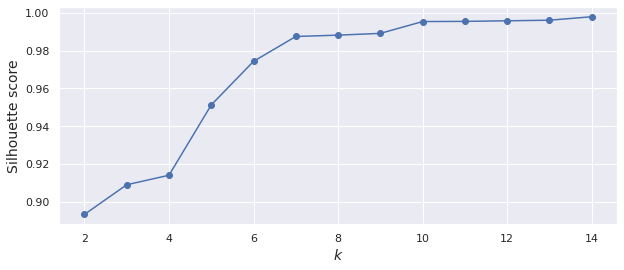


 Optimal number of components for the given Feature Set is: 11

 Optimal k retrieved in: 1391.8896385639991 seconds!! 


 Gaussian preformed in: 4.940514343999894 seconds!! 


 Cluster Sizes:  {0: 66902, 1: 1407, 2: 7913, 3: 2695, 4: 2592, 5: 1622, 6: 10374, 7: 6061, 8: 434}

 Average values for each categories per cluster


,accident_severity,road.speed_limit
0,3.0,30.0
1,2.0,60.0
2,3.0,40.0
3,3.0,70.0
4,3.0,50.0
5,3.0,20.0
6,2.0,30.0
7,3.0,60.0
8,1.0,30.0



 Time Taken: 1397.081129874


In [24]:
print('\n\n Result of GMM Modeling for feature Set 1 \n\n')
# Removing the top 20000 outliers for feature set 1 || Matrices[0]
dataframe_optimized_set1 = remove_top_20000_outliers(matrices[0])

startTime1 = timer.default_timer() #starting timer
mean_df = model_data(dataframe_optimized_set1)
endTime1 = timer.default_timer() #ending timer

mean_df.to_csv('accident_severity_vs_speed.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n Time Taken: {}'.format(endTime1 - startTime1))

**9-e: GMM on Feature Set 2 (accident_severity, time)**



 Result of GMM Modeling for Feature Set 2 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    5.3s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 3.188s

 Outlier Rank: 1 
 accident: accident_severity    1
time                 0
Name: 784, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity    1
time                 0
Name: 13292, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity    1
time                 0
Name: 13302, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity    1
time                 0
Name: 13321, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity    1
time                 0
Name: 13343, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity    1
time                 0
Name: 26168, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity    1
time                 0
Name: 33060, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity    1
time                 0
Name: 33698, dtype: int64

 Outlier Rank: 9 
 accident: accident_severity    1
time                 0
Name: 36425, dtype: int64

 Outlier Rank: 10 
 accident: accident_se

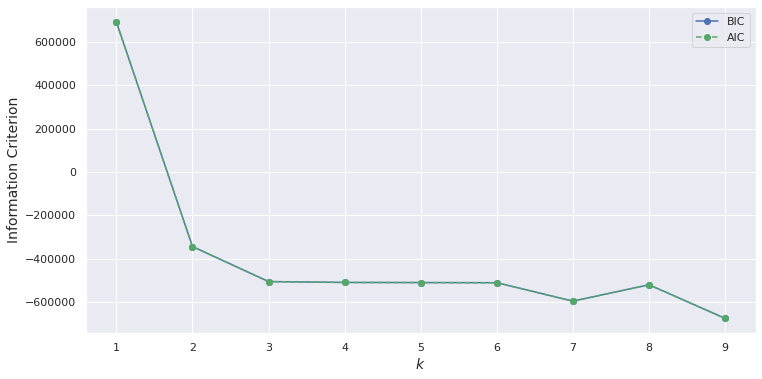


 Optimal number of components for the given Feature Set is: 9


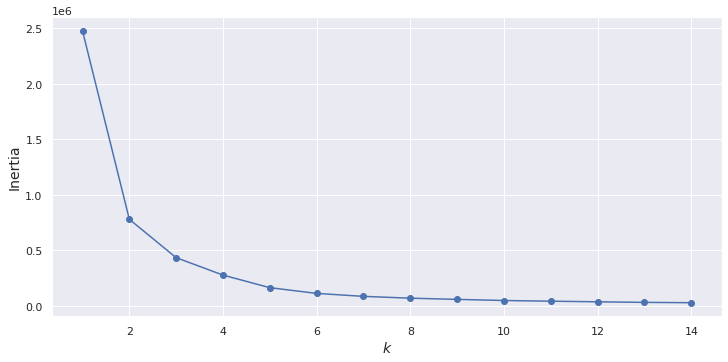


 Silhouette Scores: {2: 0.6009759616222347, 3: 0.5337105936420904, 4: 0.5295183693603164, 5: 0.5558876246550153, 6: 0.5550868461118774, 7: 0.5520235286881143, 8: 0.5482429685065373, 9: 0.5534917310671479, 10: 0.5582592342143794, 11: 0.6160323986393491, 12: 0.5967690752892622, 13: 0.6127880553369283, 14: 0.660207715009597}


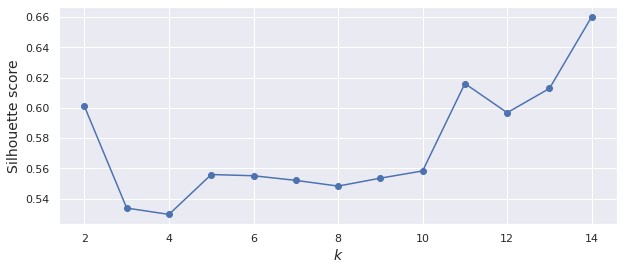


 Optimal number of components for the given Feature Set is: 10

 Optimal k retrieved in: 1494.086239444001 seconds!! 


 Gaussian preformed in: 33.42284390600071 seconds!! 


 Cluster Sizes:  {2: 57201, 3: 7007, 4: 721, 5: 13455, 6: 13482, 8: 8134}

 Average values for each categories per cluster


,accident_severity,time
0,NaN,NaN
1,NaN,NaN
2,3.0,11.269034
3,3.0,16.000000
4,1.0,13.538141
5,3.0,20.469788
6,2.0,13.679054
7,NaN,NaN
8,3.0,17.000000




 Time Taken: 1527.730570369


In [0]:
print('\n\n Result of GMM Modeling for Feature Set 2 \n\n')

# Removing the top 20000 outliers for Feature set 2 || Matrices[1]
dataframe_optimized_set2 = remove_top_20000_outliers(matrices[1])

startTime1 = timer.default_timer() #Starting timer
mean_df = model_data(dataframe_optimized_set2)
endTime1 = timer.default_timer()  #Ending timer

mean_df.to_csv('accident_severity_vs_time.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n\n Time Taken: {}'.format(endTime1 - startTime1))

**9-f: GMM on Feature Set 3 (accident_severity, number_of_vehicles)**



 Result of GMM Modeling for Feature Set 3 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    5.0s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 2.275s

 Outlier Rank: 1 
 accident: accident_severity     1
number_of_vehicles    6
Name: 13268, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity     1
number_of_vehicles    6
Name: 36401, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity     1
number_of_vehicles    6
Name: 97885, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity     1
number_of_vehicles    5
Name: 21203, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity     1
number_of_vehicles    5
Name: 44336, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity     1
number_of_vehicles    4
Name: 13275, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity     1
number_of_vehicles    4
Name: 19276, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity     1
number_of_vehicles    4
Name: 21983, dtype: int64

 Outlier Rank: 9 
 accident: accident_severity     1
number_of_vehicles    4
Name: 30322, dtype: int64

 Outlier Rank: 10 
 a

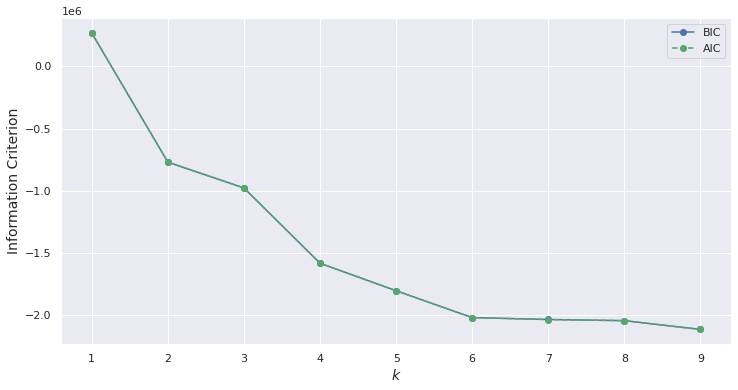


 Optimal number of components for the given Feature Set is: 9


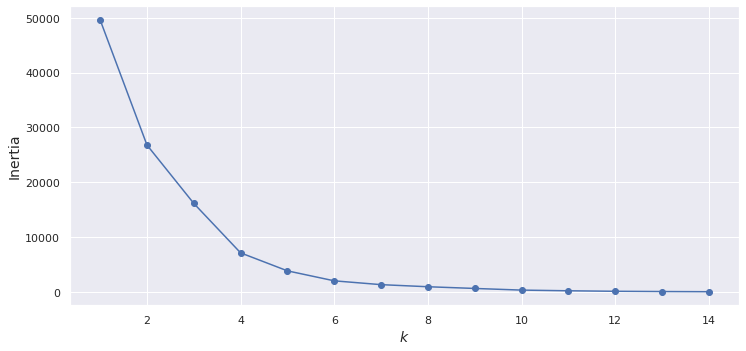


 Silhouette Scores: {2: 0.7033426362459495, 3: 0.7764277220421356, 4: 0.899000453157279, 5: 0.9551603001679665, 6: 0.9703457634215089, 7: 0.9821245284282272, 8: 0.9848291779846035, 9: 0.9893226946300927, 10: 0.9951881578939313, 11: 0.997234224987967, 12: 0.9979198288667158, 13: 0.9988140420228583, 14: 0.9992516209663672}


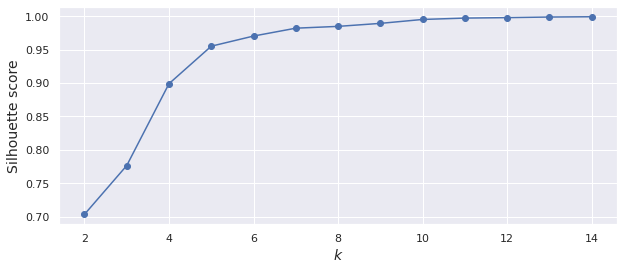


 Optimal number of components for the given Feature Set is: 11

 Optimal k retrieved in: 1473.7067200809997 seconds!! 


 Gaussian preformed in: 8.953583209999124 seconds!! 


 Cluster Sizes:  {0: 61183, 1: 7518, 2: 17597, 3: 262, 4: 5785, 5: 5135, 6: 721, 7: 1128, 8: 671}

 Average values for each categories per cluster


,accident_severity,number_of_vehicles
0,3.000000,2.000000
1,2.000000,2.000000
2,3.000000,1.000000
3,2.847328,5.339695
4,3.000000,3.000000
5,2.000000,1.000000
6,1.000000,1.689320
7,2.895390,4.000000
8,2.000000,3.000000




 Time Taken: 1482.9256973419997


In [0]:
print('\n\n Result of GMM Modeling for Feature Set 3 \n\n')

# Removing the top 20000 outliers for feature set 3 || Matrices[2]
dataframe_optimized_set3 = remove_top_20000_outliers(matrices[2])

startTime1 = timer.default_timer() #Starting timer
mean_df = model_data(dataframe_optimized_set3)
endTime1 = timer.default_timer()   #Ending timer

mean_df.to_csv('accident_severity_vs_num_vehicles.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n\n Time Taken: {}'.format(endTime1 - startTime1))

**9-g: GMM on Feature Set 4 (accident_severity, road_surface_condition)**



 Result of GMM Modeling for Feature Set 4 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    5.2s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 2.161s

 Outlier Rank: 1 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 13268, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 19276, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 30673, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 30829, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 36401, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 42409, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 53806, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity              1
road.road_surface_condition    0
Name: 53

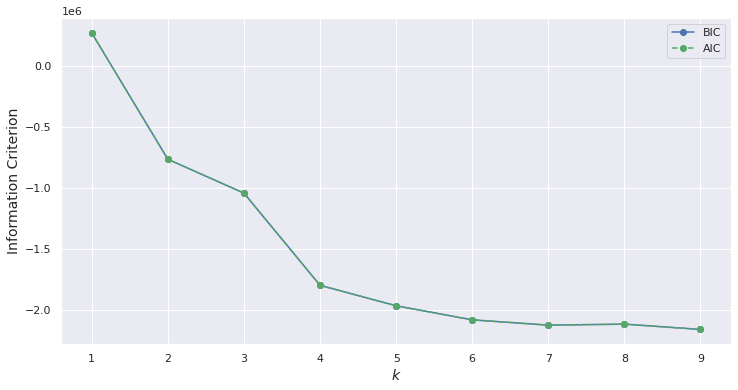


 Optimal number of components for the given Feature Set is: 9


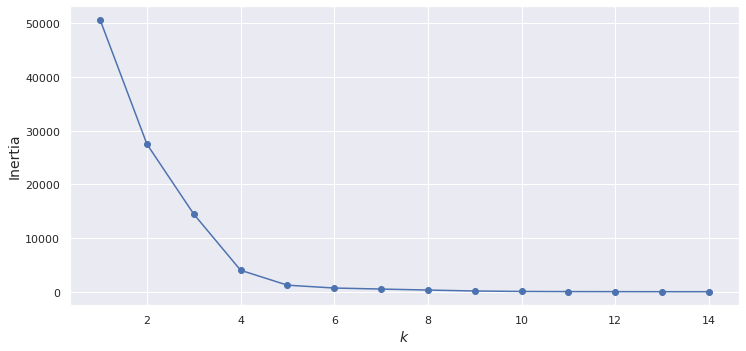


 Silhouette Scores: {2: 0.7415600359188985, 3: 0.7866472205496632, 4: 0.9336139341517041, 5: 0.9838177061159104, 6: 0.9924826442269633, 7: 0.9912876218247939, 8: 0.9949823630917296, 9: 0.9974682356096308, 10: 0.9990996915071039, 11: 0.9995793635203484, 12: 0.9997860697643103, 13: 0.999960078125, 14: 1.0}


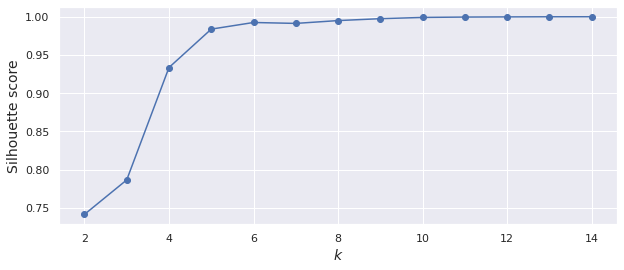


 Optimal number of components for the given Feature Set is: 11

 Optimal k retrieved in: 1342.2043535340008 seconds!! 


 Gaussian preformed in: 4.922651316999691 seconds!! 


 Cluster Sizes:  {0: 3627, 1: 59666, 2: 24591, 3: 301, 4: 9652, 5: 1209, 6: 511, 7: 248, 8: 195}

 Average values for each categories per cluster


,accident_severity,road.road_surface_condition
0,2.000000,4.000000
1,3.000000,3.000000
2,3.000000,4.000000
3,2.225914,0.727575
4,2.000000,3.000000
5,3.000000,0.000000
6,1.000000,3.000000
7,3.000000,1.000000
8,1.000000,4.000000




 Time Taken: 1347.3689151809995


In [20]:
print('\n\n Result of GMM Modeling for Feature Set 4 \n\n')
# Removing the top 20000 outliers for feature set 4 || Matrices[3]
dataframe_optimized_set4 = remove_top_20000_outliers(matrices[3])

startTime1 = timer.default_timer() #Starting timer
mean_df = model_data(dataframe_optimized_set4)
endTime1 = timer.default_timer()   #Ending timer

mean_df.to_csv('accident_severity_vs_road_condition.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n\n Time Taken: {}'.format(endTime1 - startTime1))

**9-h: GMM on Feature Set 5 (accident_severity, light_condition)**



 Result of GMM Modeling for feature Set 5 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    4.9s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 2.192s

 Outlier Rank: 1 
 accident: accident_severity       1
road.light_condition    0
Name: 19276, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity       1
road.light_condition    0
Name: 26309, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity       1
road.light_condition    0
Name: 30525, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity       1
road.light_condition    0
Name: 31909, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity       1
road.light_condition    0
Name: 31974, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity       1
road.light_condition    0
Name: 32376, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity       1
road.light_condition    0
Name: 42409, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity       1
road.light_condition    0
Name: 49442, dtype: int64

 Outlier Rank: 9 
 accident: accident_severity       1
road.light_condition    0
Name: 53658,

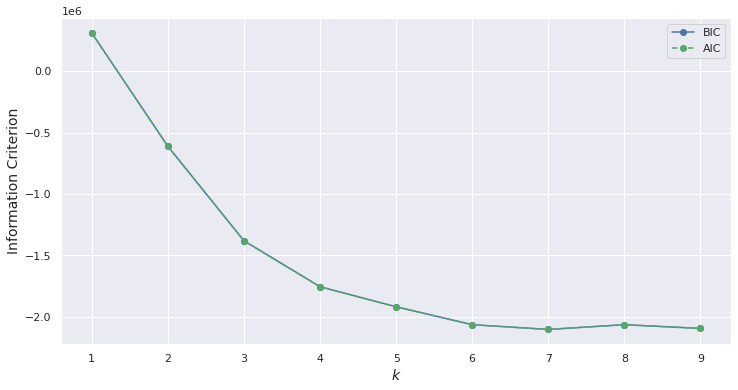


 Optimal number of components for the given Feature Set is: 7


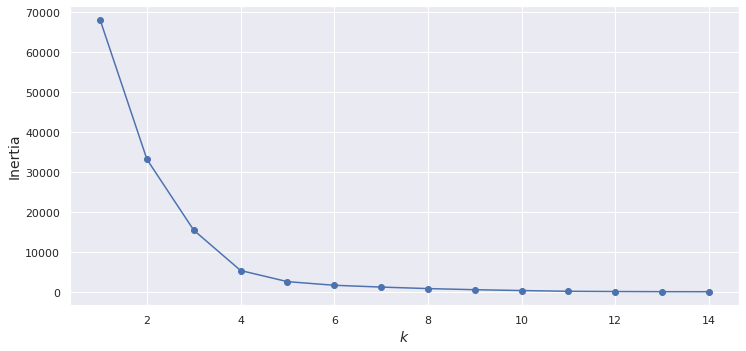


 Silhouette Scores: {2: 0.8034180094496571, 3: 0.7840526976114164, 4: 0.9228558404745968, 5: 0.9720219357851457, 6: 0.9747601186098668, 7: 0.9808149331715875, 8: 0.9851107075664542, 9: 0.9903644076592576, 10: 0.9942759188882722, 11: 0.9979716868814813, 12: 0.9991187730459867, 13: 0.9997466381494249, 14: 0.9999020100502513}


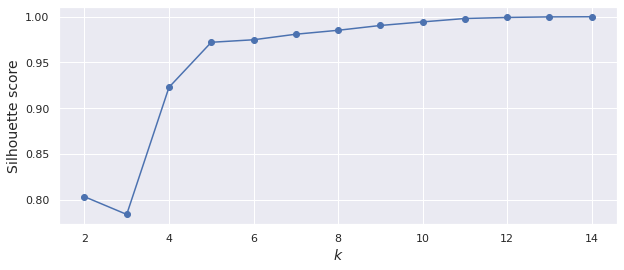


 Optimal number of components for the given Feature Set is: 11

 Optimal k retrieved in: 1359.3164907350001 seconds!! 


 Gaussian preformed in: 4.645491912999205 seconds!! 


 Cluster Sizes:  {0: 63778, 1: 3175, 2: 18844, 3: 670, 4: 9317, 5: 3563, 6: 653}

 Average values for each categories per cluster


,accident_severity,road.light_condition
0,3.0,4.0
1,3.0,1.0
2,3.0,3.0
3,1.0,4.0
4,2.0,4.0
5,2.0,3.0
6,2.0,1.0



 Time Taken: 1364.171905778001


In [27]:
print('\n\n Result of GMM Modeling for feature Set 5 \n\n')
# Removing the top 20000 outliers for feature set 5 || Matrices[4]
dataframe_optimized_set5 = remove_top_20000_outliers(matrices[4])

startTime1 = timer.default_timer() #starting timer
mean_df = model_data(dataframe_optimized_set5)
endTime1 = timer.default_timer() #ending timer

mean_df.to_csv('accident_severity_vs_light_condition.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n Time Taken: {}'.format(endTime1 - startTime1))

**9-i: GMM on Feature Set 6 (accident_severity, weather_condition)**



 Result of GMM Modeling for feature Set 6 




/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:    0.3s remaining:    5.6s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    0.4s finished



 Isolation Forest: Running Time = 2.350s

 Outlier Rank: 1 
 accident: accident_severity    1
weather.condition    2
Name: 63351, dtype: int64

 Outlier Rank: 2 
 accident: accident_severity    1
weather.condition    3
Name: 19747, dtype: int64

 Outlier Rank: 3 
 accident: accident_severity    1
weather.condition    3
Name: 29100, dtype: int64

 Outlier Rank: 4 
 accident: accident_severity    1
weather.condition    3
Name: 42880, dtype: int64

 Outlier Rank: 5 
 accident: accident_severity    1
weather.condition    3
Name: 52233, dtype: int64

 Outlier Rank: 6 
 accident: accident_severity    1
weather.condition    3
Name: 62783, dtype: int64

 Outlier Rank: 7 
 accident: accident_severity    1
weather.condition    3
Name: 64684, dtype: int64

 Outlier Rank: 8 
 accident: accident_severity    1
weather.condition    3
Name: 92363, dtype: int64

 Outlier Rank: 9 
 accident: accident_severity    1
weather.condition    3
Name: 97838, dtype: int64

 Outlier Rank: 10 
 accident: accident_

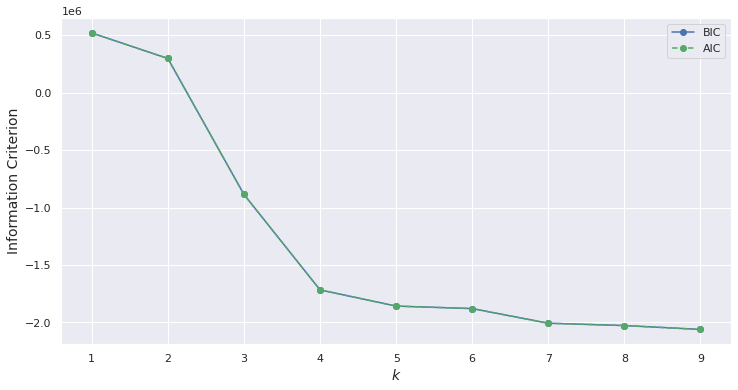


 Optimal number of components for the given Feature Set is: 9


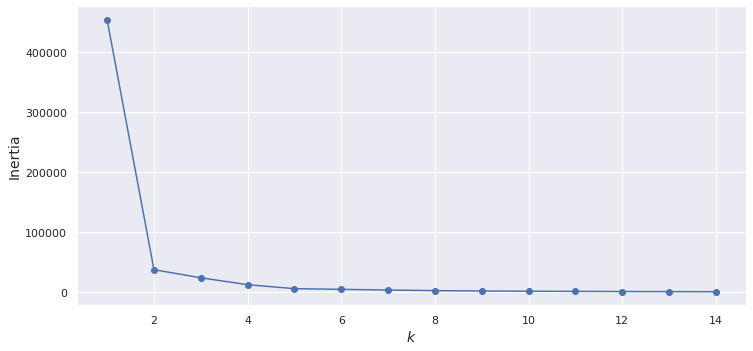


 Silhouette Scores: {2: 0.9164026752822245, 3: 0.8688844696952626, 4: 0.9023243025827267, 5: 0.9506270198347133, 6: 0.9476009567425839, 7: 0.9494524935034716, 8: 0.9670975129005616, 9: 0.975596085877581, 10: 0.9824805042581359, 11: 0.9854620110758087, 12: 0.988484310287304, 13: 0.9910771536810931, 14: 0.9940350815884841}


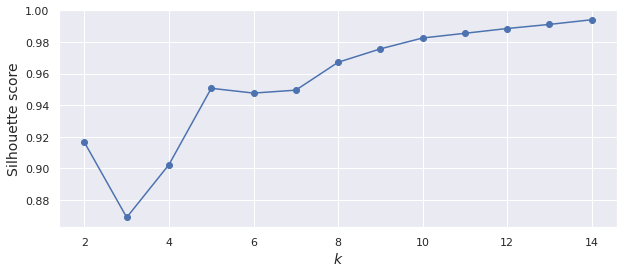


 Optimal number of components for the given Feature Set is: 11

 Optimal k retrieved in: 1406.8631711050002 seconds!! 


 Gaussian preformed in: 8.849234094999701 seconds!! 


 Cluster Sizes:  {0: 68692, 1: 11747, 2: 11133, 3: 1750, 4: 1655, 5: 1628, 6: 1732, 7: 606, 8: 1057}

 Average values for each categories per cluster


,accident_severity,weather.condition
0,3.0,6.0
1,3.0,0.0
2,2.0,6.0
3,3.0,4.0
4,3.0,8.0
5,2.0,0.0
6,3.0,4.0
7,1.0,6.0
8,3.0,7.0



 Time Taken: 1415.9636381290002


In [29]:
print('\n\n Result of GMM Modeling for feature Set 6 \n\n')
# Removing the top 20000 outliers for feature set 6 || Matrices[5]
dataframe_optimized_set6 = remove_top_20000_outliers(matrices[5])

startTime1 = timer.default_timer() #starting timer
mean_df = model_data(dataframe_optimized_set6)
endTime1 = timer.default_timer() #ending timer

mean_df.to_csv('accident_severity_vs_weather_condition.csv')
print('\n Average values for each categories per cluster')
display(mean_df)

print('\n Time Taken: {}'.format(endTime1 - startTime1))

**Code that will describe numerical labels for each textual data after feature extraction**

In [28]:
df_temp = data.copy()
columns = df_temp.columns.values

columns_with_textual_data =['weather.condition', 'road.road_surface_condition', 'road.light_condition']

for option in columns_with_textual_data:
  for column in columns:
    text_digit_vals = {}
    def convert_to_int(val):
      return text_digit_vals[val]

    if column == option:
      column_values = df_temp[column].values.tolist()
      unique_values = set(column_values)
      x = 0
      for unique_val in unique_values:
        if unique_val not in text_digit_vals:
          text_digit_vals[unique_val] = x
          print('{}: {}'.format(unique_val, x))
          x += 1

  print('\n')


Raining without high winds: 0
Snowing with high winds: 1
Snowing without high winds: 2
Fine with high winds: 3
Other: 4
Fog or mist: 5
Fine without high winds: 6
Raining with high winds: 7
Unknown: 8


Frost/Ice: 0
Snow: 1
Flood (Over 3cm of water): 2
Dry: 3
Wet/Damp: 4


Darkeness: No street lighting: 0
Darkness: Street lighting unknown: 1
Darkness: Street lights present but unlit: 2
Darkness: Street lights present and lit: 3
Daylight: Street light present: 4


